In [9]:
import os
import sys
import argparse
import cv2
import random
import colorsys
import requests
from io import BytesIO

import skimage.io
from skimage.measure import find_contours
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms as pth_transforms
import numpy as np
from PIL import Image

from scipy.linalg import eigh, inv
from scipy.sparse import identity
from scipy import ndimage
from sklearn.cluster import KMeans

import utils
sys.path.append("..") # append parent path
import models.vision_transformer as vits

import glob
import json

root = 'vis_examples/' # 이미지 저장 위치
coco_annotations_file = '/home/shhan/oicr/data/coco/annotations/instances_val2017.json' # annotation path
coco_images_dir = "/home/shhan/oicr/data/coco/images/val2017" # data path

In [10]:
from collections import defaultdict
import json
import numpy as np
class COCOParser:
    def __init__(self, anns_file, imgs_dir):
        with open(anns_file, 'r') as f:
            coco = json.load(f)
            
        self.annIm_dict = defaultdict(list)        
        self.cat_dict = {} 
        self.annId_dict = {}
        self.im_dict = {}
        self.licenses_dict = {}
        for ann in coco['annotations']:           
            self.annIm_dict[ann['image_id']].append(ann) 
            self.annId_dict[ann['id']]=ann
        for img in coco['images']:
            self.im_dict[img['id']] = img
        for cat in coco['categories']:
            self.cat_dict[cat['id']] = cat
        for license in coco['licenses']:
            self.licenses_dict[license['id']] = license
    def get_imgIds(self):
        return list(self.im_dict.keys())
    def get_annIds(self, im_ids):
        im_ids=im_ids if isinstance(im_ids, list) else [im_ids]
        return [ann['id'] for im_id in im_ids for ann in self.annIm_dict[im_id]]
    def load_anns(self, ann_ids):
        im_ids=ann_ids if isinstance(ann_ids, list) else [ann_ids]
        return [self.annId_dict[ann_id] for ann_id in ann_ids]        
    def load_cats(self, class_ids):
        class_ids=class_ids if isinstance(class_ids, list) else [class_ids]
        return [self.cat_dict[class_id] for class_id in class_ids]
    def get_imgLicenses(self,im_ids):
        im_ids=im_ids if isinstance(im_ids, list) else [im_ids]
        lic_ids = [self.im_dict[im_id]["license"] for im_id in im_ids]
        return [self.licenses_dict[lic_id] for lic_id in lic_ids]

In [11]:
coco= COCOParser(coco_annotations_file, coco_images_dir)

In [7]:
coco.im_dict

NameError: name 'coco' is not defined

In [8]:
coco.im_dict[143]

NameError: name 'coco' is not defined

In [6]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
# define a list of colors for drawing bounding boxes

def get_gt(img_path, orig_img, pad):
    if img_path.split('/')[6][-4:] == '2017':
        img_id = int(img_path.split('/')[-1].split('.')[0])
    else:
        img_id = int(img_path.split('/')[-1].split('_')[-1].split('.')[0])
    print(img_id)
    color_list = ["pink", "red", "teal", "blue", "orange", "yellow", "black", "magenta","green","aqua"]*10
    selected_img_ids = [img_id]
    # print(selected_img_ids)
    ann_ids = coco.get_annIds(selected_img_ids)
    im_licenses = coco.get_imgLicenses(selected_img_ids)
    fig = plt.plot(figsize=(15,10))
    # ax = ax.ravel()
    im = selected_img_ids[0]
    image = orig_img#Image.open(img_path)
    #image = Image.open(f"{coco_images_dir}/{coco_image_name}{str(im).zfill(12)}.jpg\'")
    ann_ids = coco.get_annIds(im)
    annotations = coco.load_anns(ann_ids)
    i = 0
    for ann in annotations[:-2]:
        bbox = ann['bbox']
        x, y, w, h = [int(b) for b in bbox]; x+=pad[0]; y+=pad[1]
        class_id = ann["category_id"]
        class_name = coco.load_cats(class_id)[0]["name"]
        license = coco.get_imgLicenses(im)[0]["name"]
        color_ = color_list[class_id]
        rect = plt.Rectangle((x, y), w, h, linewidth=2, edgecolor=color_, facecolor='none')
        t_box=plt.text(x, y, class_name,  color='red', fontsize=10)
        t_box.set_bbox(dict(boxstyle='square, pad=0',facecolor='white', alpha=0.6, edgecolor='blue'))
        plt.gca().add_patch(rect)
        # print(rect)
    plt.axis('off')
    plt.imshow(image)
    plt.tight_layout()
    plt.show()

In [130]:
pad

[20, 70]

In [7]:
def apply_mask(image, mask, color, alpha=0.5):
    for c in range(3):
        image[:, :, c] = image[:, :, c] * (1 - alpha * mask) + alpha * mask * color[c] * 255
    return image

def random_colors(N, bright=True):
    """
    Generate random colors.
    """
    brightness = 1.0 if bright else 0.7
    hsv = [(i / N, 1, brightness) for i in range(N)]
    colors = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
    random.shuffle(colors)
    return colors


def display_instances(image, mask, fname="test", figsize=(5, 5), blur=False, contour=True, alpha=0.5):
    fig = plt.figure(figsize=figsize, frameon=False)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    ax = plt.gca()

    N = 1
    mask = mask[None, :, :]
    # Generate random colors
    colors = random_colors(N)

    # Show area outside image boundaries.
    height, width = image.shape[:2]
    margin = 0
    ax.set_ylim(height + margin, -margin)
    ax.set_xlim(-margin, width + margin)
    ax.axis('off')
    masked_image = image.astype(np.uint32).copy()
    for i in range(N):
        color = colors[i]
        _mask = mask[i]
        if blur:
            _mask = cv2.blur(_mask,(10,10))
        # Mask
        masked_image = apply_mask(masked_image, _mask, color, alpha)
        # Mask Polygon
        # Pad to ensure proper polygons for masks that touch image edges.
        if contour:
            padded_mask = np.zeros((_mask.shape[0] + 2, _mask.shape[1] + 2))
            padded_mask[1:-1, 1:-1] = _mask
            contours = find_contours(padded_mask, 0.5)
            for verts in contours:
                # Subtract the padding and flip (y, x) to (x, y)
                verts = np.fliplr(verts) - 1
                p = Polygon(verts, facecolor="none", edgecolor=color)
                ax.add_patch(p)
    ax.imshow(masked_image.astype(np.uint8), aspect='auto')
    fig.savefig(fname)
    print(f"{fname} saved.")
    return

def multi_plot(img_list, title_list, col, is_short = False):
    num_img = len(img_list)
    if is_short:
        scale = 3
    else:
        scale = 4
    height = (len(img_list) // col) * scale
    plt.rcParams['figure.figsize'] = [4*col, height]
    
    for i, single_img in enumerate(img_list):
        plt.subplot(num_img//col, col, i+1)
        # plt.gca().axes.xaxis.set_visible(False)
        # plt.gca().axes.yaxis.set_visible(False)
        plt.imshow(single_img)
        plt.title(title_list[i], fontdict={'fontsize' :15})
    plt.show()

In [8]:
parser = argparse.ArgumentParser('Visualize Self-Attention maps')
parser.add_argument('--arch', default='vit_small', type=str,
    choices=['vit_tiny', 'vit_small', 'vit_base'], help='Architecture (support only ViT atm).')
parser.add_argument('--patch_size', default=8, type=int, help='Patch resolution of the model.')
parser.add_argument('--pretrained_weights', default='', type=str,
    help="Path to pretrained weights to load.")
parser.add_argument("--checkpoint_key", default="teacher", type=str,
    help='Key to use in the checkpoint (example: "teacher")')
parser.add_argument("--image_path", default=None, type=str, help="Path of the image to load.")
parser.add_argument("--image_size", default=(480, 480), type=int, nargs="+", help="Resize image.")
parser.add_argument('--output_dir', default='.', help='Path where to save visualizations.')
parser.add_argument("--threshold", type=float, default=None, help="""We visualize masks
    obtained by thresholding the self-attention maps to keep xx% of the mass.""")
args = parser.parse_args(args=[])

args.arch = 'vit_small' # model type
args.patch_size = 8 # patch size
args.image_size = (640, 640) # input image size
args.pretrained_weights = 'small_8patch.pth' # checkpoint path
path = [
    '/home/shhan/oicr/data/coco/images/val2017/000000397133.jpg', # birds
    '/home/n0/mlvu023/datasets/coco/val2014/COCO_val2014_000000000196.jpg', # food
    '/home/n0/mlvu023/datasets/coco/val2014/COCO_val2014_000000000357.jpg', # baseball players
    '/home/n0/mlvu023/datasets/coco/val2014/COCO_val2014_000000000599.jpg', # cat
    '/home/n0/mlvu023/datasets/coco/val2014/COCO_val2014_000000000761.jpg', # skiers
    #'/home/jeongwoo/data/dataset/imagenet/1K_dataset/train/n02708093/n02708093_141.JPEG', # imagenet, clock
    
]
args.image_path = path[0] # single image path

In [9]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
# build model
model = vits.__dict__[args.arch](patch_size=args.patch_size, num_classes=0)
for p in model.parameters():
    p.requires_grad = False
model.eval()
model.to(device)
if os.path.isfile(args.pretrained_weights):
    state_dict = torch.load(args.pretrained_weights, map_location="cpu")
    if args.checkpoint_key is not None and args.checkpoint_key in state_dict:
        print(f"Take key {args.checkpoint_key} in provided checkpoint dict")
        state_dict = state_dict[args.checkpoint_key]
    # remove `module.` prefix
    state_dict = {k.replace("module.", ""): v for k, v in state_dict.items()}
    # remove `backbone.` prefix induced by multicrop wrapper
    state_dict = {k.replace("backbone.", ""): v for k, v in state_dict.items()}
    msg = model.load_state_dict(state_dict, strict=False)
    print('Pretrained weights found at {} and loaded with msg: {}'.format(args.pretrained_weights, msg))
else:
    print("Please use the `--pretrained_weights` argument to indicate the path of the checkpoint to evaluate.")
    url = None
    if args.arch == "vit_small" and args.patch_size == 16:
        url = "dino_deitsmall16_pretrain/dino_deitsmall16_pretrain.pth"
    elif args.arch == "vit_small" and args.patch_size == 8:
        url = "dino_deitsmall8_300ep_pretrain/dino_deitsmall8_300ep_pretrain.pth"  # model used for visualizations in our paper
    elif args.arch == "vit_base" and args.patch_size == 16:
        url = "dino_vitbase16_pretrain/dino_vitbase16_pretrain.pth"
    elif args.arch == "vit_base" and args.patch_size == 8:
        url = "dino_vitbase8_pretrain/dino_vitbase8_pretrain.pth"
    if url is not None:
        print("Since no pretrained weights have been provided, we load the reference pretrained DINO weights.")
        state_dict = torch.hub.load_state_dict_from_url(url="https://dl.fbaipublicfiles.com/dino/" + url)
        model.load_state_dict(state_dict, strict=True)
    else:
        print("There is no reference weights available for this model => We use random weights.")

# open image
if args.image_path is None:
    # user has not specified any image - we use our own image
    print("Please use the `--image_path` argument to indicate the path of the image you wish to visualize.")
    print("Since no image path have been provided, we take the first image in our paper.")
    response = requests.get("https://dl.fbaipublicfiles.com/dino/img.png")
    orig_img = Image.open(BytesIO(response.content))
    orig_img = orig_img.convert('RGB')
elif os.path.isfile(args.image_path):
    with open(args.image_path, 'rb') as f:
        orig_img = Image.open(f)
        orig_img = orig_img.convert('RGB')
else:
    print(f"Provided image path {args.image_path} is non valid.")
    sys.exit(1)

pad = [(640-orig_img.size[0])//2, (640-orig_img.size[1])//2, (640-orig_img.size[0])//2, (640-orig_img.size[1])//2]
if (640-orig_img.size[0])%2 != 0:
    pad[0] = pad[0]+1
if (640-orig_img.size[1])%2 != 0:
    pad[1] = pad[1]+1

transform_org = pth_transforms.Compose([
    pth_transforms.Pad(pad),
])
orig_img = transform_org(orig_img)

transform = pth_transforms.Compose([
    #pth_transforms.Resize(args.image_size),
    #pth_transforms.Pad(pad), # https://pytorch.org/vision/main/generated/torchvision.transforms.Pad.html
    pth_transforms.ToTensor(),
    pth_transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])
img = transform(orig_img)

# make the image divisible by the patch size
w, h = img.shape[1] - img.shape[1] % args.patch_size, img.shape[2] - img.shape[2] % args.patch_size
img = img[:, :w, :h].unsqueeze(0)
w_featmap = img.shape[-2] // args.patch_size
h_featmap = img.shape[-1] // args.patch_size

attentions, _x_ctxed, _x_final = model.get_last_selfattention(img.to(device)) # 1 head 1+tokens 1+tokens
# _x_ctxed : 마지막 layer에서 나온 x token
# vision_transformer.py에서 class block의 forward를 다음과 같이 수정
"""
def forward(self, x, return_attention=False):
    y, attn = self.attn(self.norm1(x))
    x = x + self.drop_path(y)
    x = x + self.drop_path(self.mlp(self.norm2(x)))
    if return_attention:
        return attn, y, x
    return x
"""


Please use the `--pretrained_weights` argument to indicate the path of the checkpoint to evaluate.
Since no pretrained weights have been provided, we load the reference pretrained DINO weights.


'\ndef forward(self, x, return_attention=False):\n    y, attn = self.attn(self.norm1(x))\n    x = x + self.drop_path(y)\n    x = x + self.drop_path(self.mlp(self.norm2(x)))\n    if return_attention:\n        return attn, y, x\n    return x\n'

(6400, 5)


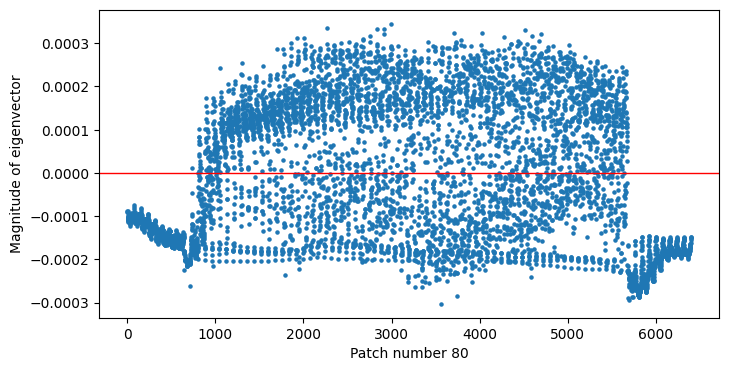

In [10]:
"""
"""
cls_attn = attentions.mean(1).squeeze()[0,1:].reshape(w_featmap, h_featmap)
num_eig = 5 # 사용할 eigenvector 개수

x_ctxed = _x_ctxed.squeeze()[1:, :] # N D
x_ctxed = F.normalize(x_ctxed,p=2)
x_ctxed_aff = x_ctxed @ x_ctxed.transpose(1,0) # N N
affinity_mat = x_ctxed_aff.clone()
attn = x_ctxed_aff.sum(dim=-1) # N

attn_norm_min = attn.min()
if attn_norm_min < 0:
    attn = attn - attn_norm_min + 1e-10
# attn /= attn.squeeze().sum()
attn = attn.reshape(w_featmap, h_featmap)
# attn = attentions.mean(1).squeeze()[0, 1:].squeeze().reshape(w_featmap, h_featmap) # num_patch num_patch
# attn_raw = attn.clone()
# attn = nn.functional.interpolate(attn.unsqueeze(0).unsqueeze(0), scale_factor=args.patch_size, mode='nearest')[0].squeeze().numpy()
# fname = 'attn_map.png'
# plt.imsave(fname=fname, arr=attn, format='png')
"""
"""
def ncut(feats, patch_num, tau = 0.2, eps=1e-5, no_binary_graph=False, flip=False, force_flip=False):
     # cls_token = feats[0,0:1,:].cpu().numpy() 
    A = feats.numpy() # attention map, [196, 196]
    N = A.shape[0]
    # A = A > tau # [196 196]
    # A = np.where(A.astype(float) == 0, eps, A) # 0->epsilon, else same
    A = np.where(A.astype(float) <= tau, eps, A) # 0->epsilon, else same
    d_i = np.sum(A, axis=1) # [196 1] -> [196]
    D = np.diag(d_i) # [196 196] to diagonal, ex. [a b c] -> [a 0 0] [0 b 0] [0 0 c]
    
    laplacian = D - A
    # laplacian = identity(N).toarray() - (inv(D) @ A)
    # Print second and third smallest eigenvector 
    eigenvalues, eigenvectors = eigh(laplacian, D, subset_by_index=[1,num_eig])
    print(eigenvectors.shape)

    # Using average point to compute bipartition 
    second_smallest_vec = eigenvectors[:, 0] # [M]
    avg = np.sum(second_smallest_vec) / len(second_smallest_vec)
    #avg = 0
    # print(f'Average is {avg}')
    bipartition = second_smallest_vec > avg # [M]
    bipartition = bipartition.reshape(*patch_num).astype(float) # [14, 14]
    
    return bipartition, second_smallest_vec, eigenvectors

mask, eigenvec, full_eigen = ncut(affinity_mat, (w_featmap, h_featmap), tau = 0.2)
# mask = torch.tensor(mask)
# mask = mask.flatten()

eigenvec_sorted = np.sort(eigenvec)
x_val = list(range(int(eigenvec.shape[0])))
plt.figure(figsize=[8,4])
plt.scatter(x_val, eigenvec, s=5)
plt.axhline(y=0, color='r', linewidth=1)
plt.ylabel('Magnitude of eigenvector')

plt.xlabel(f'Patch number {int(attn.shape[0])}')
plt.show()
# 나오는 figure는 eivenvector의 각 element의 값 (=patch의 개수)

In [11]:
full_eigen.shape

(6400, 5)

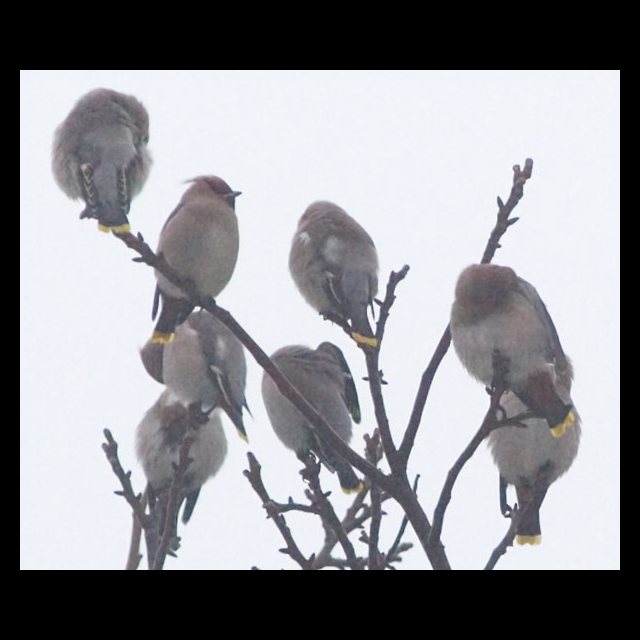

In [13]:
orig_img

In [ ]:
orig_img.size

torch.Size([1, 3, 640, 640])
(3, 640, 640)
(640, 640, 3)


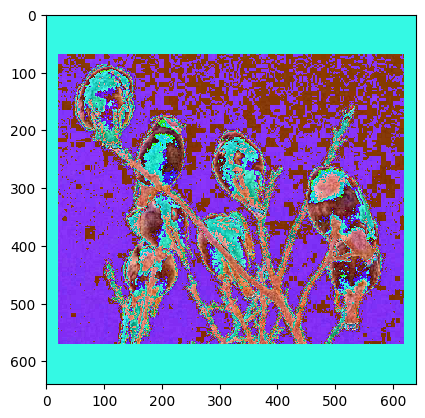

In [14]:
print(img.shape)
temp = img
temp = temp.detach().cpu().numpy() # tensor -> numpy
temp = temp.reshape((temp.shape[1:]))
print(temp.shape)
temp = np.transpose(temp, (1, 2, 0)) # [C,H,W] -> [H,W,C]
print(temp.shape)
temp = temp*255#denormalize(temp) # *255 or IMAGENET denorm 방법
temp = cv2.cvtColor(temp, cv2.COLOR_BGR2RGB) # RGB 채널
temp = temp.astype(np.uint8).copy() # np.float32 -> np.uint8

plt.imshow(temp, interpolation='nearest')
plt.show()

In [15]:
def visualization(orig_img, cls_attn, attn, clustered):
    cls_attn = nn.functional.interpolate(cls_attn.unsqueeze(0).unsqueeze(0), scale_factor=args.patch_size, mode="nearest")[0][0]
    th_attn = nn.functional.interpolate(attn.unsqueeze(0).unsqueeze(0), scale_factor=args.patch_size, mode="nearest")[0][0]
    clustered = nn.functional.interpolate(clustered.unsqueeze(0).unsqueeze(0), scale_factor=args.patch_size, mode="nearest")[0][0]
    print(cls_attn.shape, th_attn.shape, clustered.shape)
    
    # # orig_img = orig_img.resize((224,224))
    np_img = np.array(orig_img)
    #np_img = np_img.astype(np.float32)
    fname = root + 'img.png'
    plt.imsave(fname=fname, arr=np_img, format='png')
    #read_img = cv2.imread(args.image_path)
    #original_image = cv2.cvtColor(read_img, cv2.COLOR_BGR2RGB)
    #original_image = original_image[0:w, 0:h]

    th_attn_np = np.array(th_attn)
    fname = root + 'attn.png'
    plt.imsave(fname=fname, arr=th_attn_np, format='png')
    th_attn_rgb = cv2.imread(fname)
    attention_map = cv2.cvtColor(th_attn_rgb, cv2.COLOR_BGR2RGB)
    
    cls_attn = np.array(cls_attn)
    fname = root + 'cls_attn.png'
    plt.imsave(fname=fname, arr=cls_attn, format='png')
    cls_attn = cv2.imread(fname)
    cls_attn = cv2.cvtColor(cls_attn, cv2.COLOR_BGR2RGB)
    
    partitinoed = np.array(clustered)
    fname = root + 'partitinoed.png'
    plt.imsave(fname=fname, arr=partitinoed, format='png')
    partitinoed = cv2.imread(fname)
    partitinoed = cv2.cvtColor(partitinoed, cv2.COLOR_BGR2RGB)
    #print(np_img.shape, attention_map.shape)
    #print(np_img)
    #print(attention_map)
    attn_layered = cv2.addWeighted(np_img, 0.6, attention_map, 0.2,0)
    cls_attn_layered = cv2.addWeighted(np_img, 0.6, cls_attn, 0.2,0)
    partition_layered = cv2.addWeighted(np_img, 0.6, partitinoed, 0.2,0)
    # plt.imshow(added_image)
    
    img_list = [orig_img, cls_attn, cls_attn_layered, partition_layered, th_attn, attn_layered]
    title_list = ['Image', 'Cls attn', 'Cls attn overlayed', 'Partitioned', 'Similarity based', 'Sim overlayed']
    multi_plot(img_list, title_list, 3, is_short=True)

In [52]:
k = 5 # kmeans 개수
model = KMeans(n_clusters=k, random_state=5)
model.fit(full_eigen)
result = model.fit_predict(full_eigen)
scaled = result / k
clustered = torch.tensor(scaled).reshape(w_featmap, h_featmap)

torch.Size([640, 640]) torch.Size([640, 640]) torch.Size([640, 640])


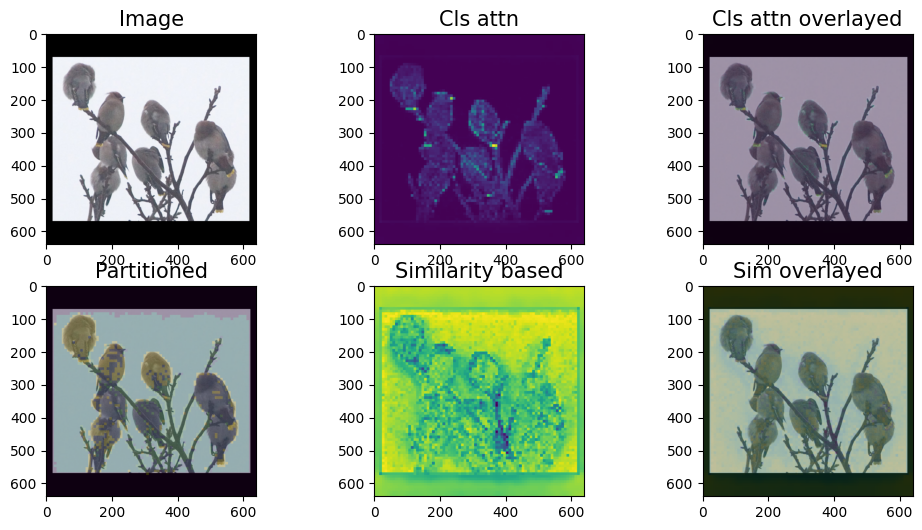

In [53]:
visualization(orig_img, cls_attn, attn, clustered)

In [34]:
def NormalizeTensor(data):
    return (data - torch.min(data)) / (torch.max(data) - torch.min(data))


In [35]:
NormalizeTensor(cls_attn)

tensor([[0.0138, 0.0127, 0.0107,  ..., 0.0098, 0.0121, 0.0138],
        [0.0128, 0.0120, 0.0102,  ..., 0.0093, 0.0112, 0.0125],
        [0.0102, 0.0100, 0.0091,  ..., 0.0082, 0.0089, 0.0093],
        ...,
        [0.0093, 0.0091, 0.0084,  ..., 0.0082, 0.0090, 0.0093],
        [0.0114, 0.0109, 0.0092,  ..., 0.0090, 0.0105, 0.0113],
        [0.0126, 0.0118, 0.0096,  ..., 0.0094, 0.0115, 0.0125]])

In [36]:
NormalizeTensor(attn)

tensor([[0.8931, 0.8941, 0.8966,  ..., 0.9025, 0.9091, 0.9133],
        [0.8919, 0.8925, 0.8951,  ..., 0.9000, 0.9057, 0.9097],
        [0.8896, 0.8897, 0.8919,  ..., 0.8944, 0.8976, 0.9003],
        ...,
        [0.8291, 0.8283, 0.8316,  ..., 0.8353, 0.8367, 0.8394],
        [0.8218, 0.8226, 0.8308,  ..., 0.8375, 0.8425, 0.8480],
        [0.8202, 0.8223, 0.8317,  ..., 0.8406, 0.8482, 0.8542]])

/tmp/ipykernel_6769/3209434811.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  plt.imshow(torch.nn.functional.softmax(cls_attn)*torch.nn.functional.softmax(attn))


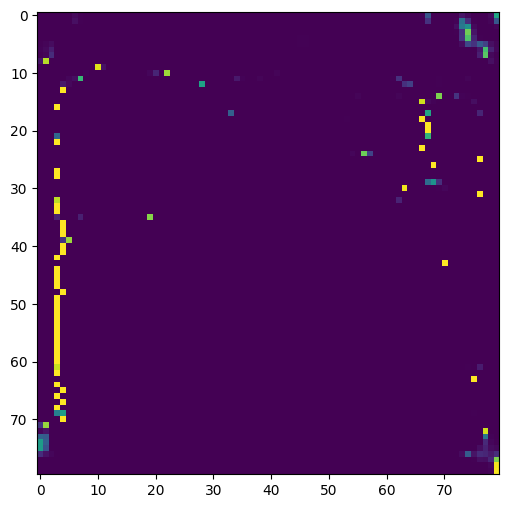

In [42]:
plt.imshow(torch.nn.functional.softmax(cls_attn)*torch.nn.functional.softmax(attn))

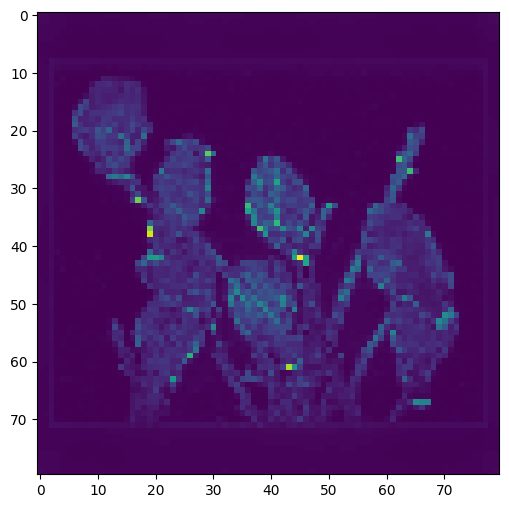

In [41]:
plt.imshow(NormalizeTensor(cls_attn)*NormalizeTensor(attn))

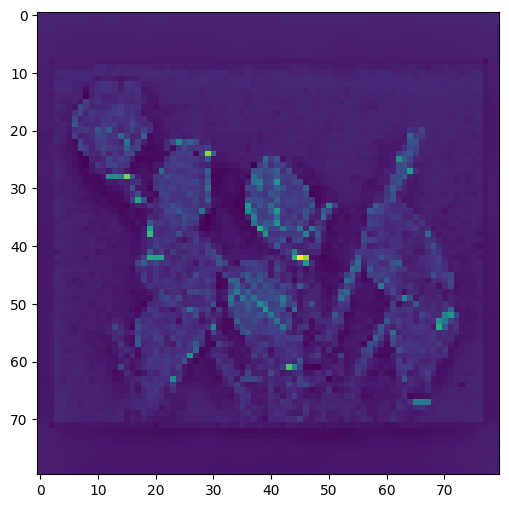

In [40]:
plt.imshow(0.8*NormalizeTensor(cls_attn)+0.2*NormalizeTensor(attn))

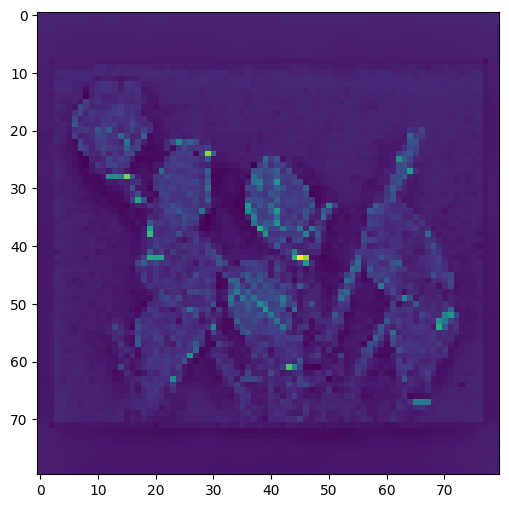

In [ ]:
plt.imshow(0.8*NormalizeTensor(cls_attn)+0.2*NormalizeTensor(attn))

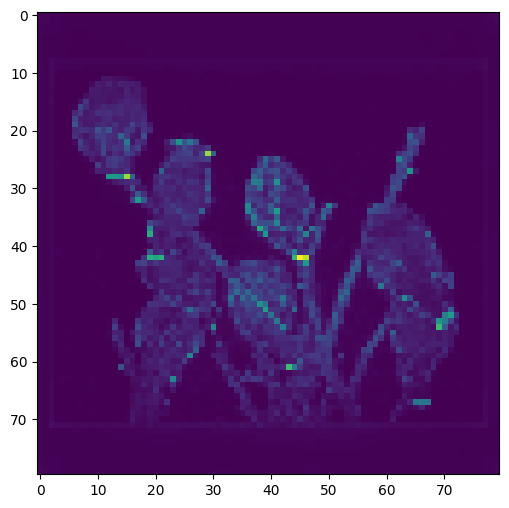

In [38]:
plt.imshow(cls_attn)

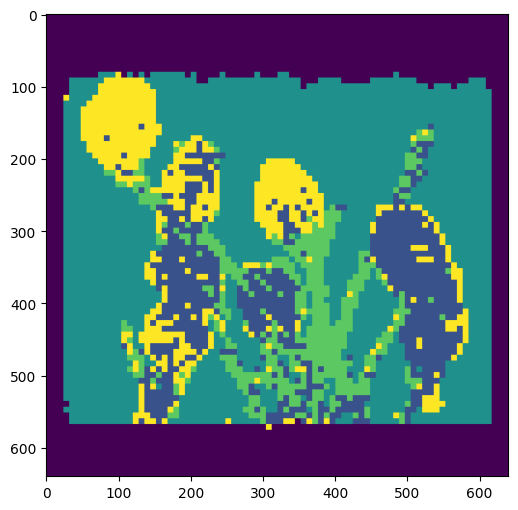

In [54]:
partitinoed = cv2.imread(root+'partitinoed.png')
partitinoed = cv2.cvtColor(partitinoed, cv2.COLOR_BGR2RGB)
plt.imshow(partitinoed)

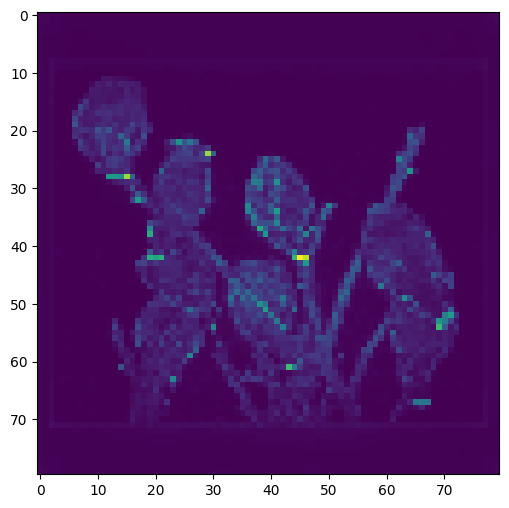

In [898]:
plt.imshow(cls_attn)

In [55]:
def bwlabel(clustered, conn): # clustered (torch)
    if (conn != 4) and (conn !=8):
        print("Incorrect connectivity. Can only be 4 or 8")
        return -1
    
    clustered = np.array(clustered) # torch -> numpy
    [x,y] = clustered.shape 
    clusters = np.unique(clustered) # the total types of clusters

    tot_labels = []
    for c in clusters:
        mask = np.array(clustered==c, dtype=bool) # True or false
        mask = mask.astype(np.int32) # 0 or 1

        # expand data not to crash when searching
        data = np.pad(mask, ((1,0),(1,1)), 'constant',constant_values=0) # pad on (top, down), (left, right)

        [x,y] = data.shape
        labels = np.zeros(data.shape)
        nextlabel = 0
        linked = {}

        for i in range(1,x): # each row
            for j in range(1,y-1): # each column
                if data[i,j] !=0: # not background
                    if (conn == 8):
                        neighborsearch = np.array([data[i-1,j-1], data[i-1,j], data[i-1,j+1], data[i,j-1]])
                    elif (conn == 4):
                        neighborsearch = np.array([data[i-1,j], data[i,j-1]])
                    # search for neighbors with binary value 1 
                    n = np.where(neighborsearch==1)[0]

                    # if no neighbor is already labeled, assign new label
                    if len(n)==0:
                        linked[nextlabel] = np.array([nextlabel])
                        labels[i,j] = nextlabel
                        nextlabel = nextlabel+1

                    # if neighbors is labeled, pick the lowest label and store the connected labels in linked
                    else:
                        if (conn == 8):
                            neighborsearch_label = np.array([labels[i-1,j-1], labels[i-1,j], labels[i-1,j+1], labels[i,j-1]])
                        elif (conn == 4):
                            neighborsearch_label = np.array([labels[i-1,j], labels[i,j-1]])

                        L = neighborsearch_label[n]
                        labels[i,j] = np.min(L)

                        for k in range(len(L)):
                            label = L[k]
                            linked[label] = np.unique(np.append(linked[label], L))

        labels = labels[1:,1:-2] # remove the previous expansion of the image

        ## for each link, look through the other links and look for common labels
        # if common labels exist they are linked, replace both link w/ the union of the two.
        # repeat until there is no change in the links.
        
        change2 = 1
        while change2 == 1:
            change = 0
            for i in range(len(linked)):
                for j in range(len(linked)):
                    if i!=j:
                        if (np.sum(np.isin(linked[i],linked[j])) >0) and \
                            (np.sum(np.isin(linked[i],linked[j])) != len(linked[i])):
                            change = 1
                            linked[i] = np.union1d(linked[i], linked[j])
                            linked[j] = linked[i]


            if change == 0:
                change2 = 0
                
        # removing redundant links
        #linked = np.unique([str(i) for i in linked]) 
        #linked = [int(i) for i in linked]

        K = len(linked)
        templabels = labels
        labels = np.zeros(labels.shape)
        # label linked labels with a single label
        for k in range(K):
            for l in range(len(linked[k])):
                labels[templabels == linked[k][l]] = k

        tot_labels.append(labels)

    return tot_labels


In [44]:
tot_labels = bwlabel(clustered, 4)

In [407]:
len(tot_labels)

10

In [406]:
# tot_labels 중 1번째 cluster에 대한 binary array의 unique한 값
np.unique(tot_labels[1])

array([ 1.,  3.,  4.,  7.,  8.,  9., 10., 11., 14., 15., 16., 17., 20.,
       21., 22., 23., 24., 25., 26., 27., 28., 29., 30., 31., 34., 35.,
       37., 38., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50.,
       51., 52., 53., 54., 55., 56., 57., 58., 59., 60., 61., 62.])

In [337]:
tot_labels[0]

array([[2., 2., 2., ..., 2., 2., 2.],
       [2., 2., 2., ..., 2., 2., 2.],
       [2., 2., 2., ..., 2., 2., 2.],
       ...,
       [2., 2., 2., ..., 2., 2., 2.],
       [2., 2., 2., ..., 2., 2., 2.],
       [2., 2., 2., ..., 2., 2., 2.]])

In [417]:
clustered.unique()

tensor([0.0000, 0.1000, 0.2000, 0.3000, 0.4000, 0.5000, 0.6000, 0.7000, 0.8000,
        0.9000], dtype=torch.float64)

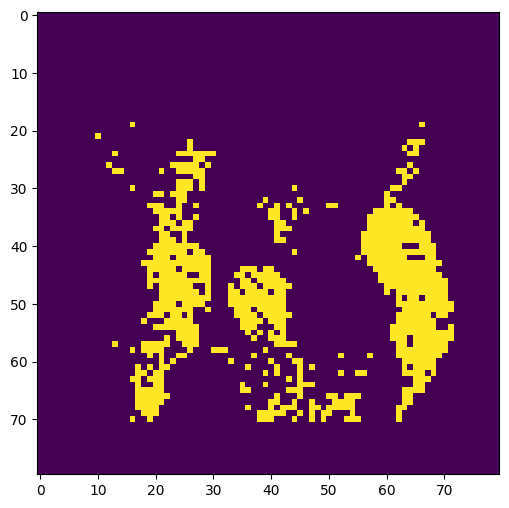

In [511]:
mask = np.array(clustered==0.2, dtype=bool) # True or false
plt.imshow(mask*255)

In [357]:
np.unique(tot_labels[1])

array([ 0.,  1.,  2.,  4.,  5.,  7., 10., 13., 14., 16., 17., 18., 20.,
       21., 22., 23., 24., 27., 31., 35., 37., 38., 39., 41., 43., 44.,
       45., 46., 48., 49., 50., 51., 52., 53., 54., 55., 56., 58., 62.,
       63., 64., 65.])

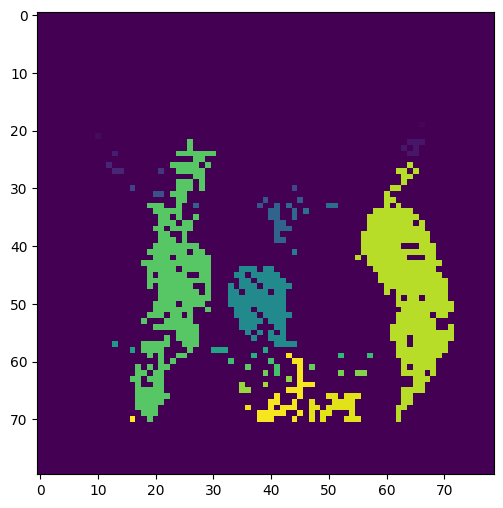

In [361]:
plt.imshow(tot_labels[1])

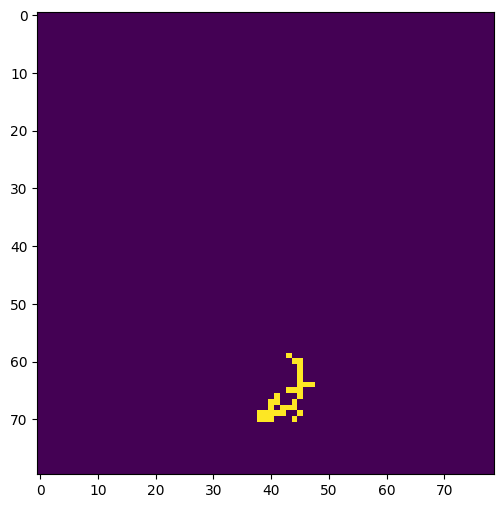

In [394]:
clst_mask = (tot_labels[1]==64)*1
plt.imshow(clst_mask)

In [466]:
cls_attn.min()

tensor(1.1007e-05)

In [ ]:
def xywh2xyxy(x):
    # Convert nx4 boxes from [x, y, w, h] to [x1, y1, x2, y2] where xy1=top-left, xy2=bottom-right
    y = x.clone() if isinstance(x, torch.Tensor) else np.copy(x)
    y[:, 0] = x[:, 0] - x[:, 2] / 2  # top left x
    y[:, 1] = x[:, 1] - x[:, 3] / 2  # top left y
    y[:, 2] = x[:, 0] + x[:, 2] / 2  # bottom right x
    y[:, 3] = x[:, 1] + x[:, 3] / 2  # bottom right y
    return y

def box_iou(box1, box2):
    # https://github.com/pytorch/vision/blob/master/torchvision/ops/boxes.py
    """
    Return intersection-over-union (Jaccard index) of boxes.
    Both sets of boxes are expected to be in (x1, y1, x2, y2) format.
    Arguments:
        box1 (Tensor[N, 4])
        box2 (Tensor[M, 4])
    Returns:
        iou (Tensor[N, M]): the NxM matrix containing the pairwise
            IoU values for every element in boxes1 and boxes2
    """

    def box_area(box):
        # box = 4xn
        return (box[2] - box[0]) * (box[3] - box[1])

    area1 = box_area(box1.T)
    area2 = box_area(box2.T)

    # inter(N,M) = (rb(N,M,2) - lt(N,M,2)).clamp(0).prod(2)
    inter = (torch.min(box1[:, None, 2:], box2[:, 2:]) - torch.max(box1[:, None, :2], box2[:, :2])).clamp(0).prod(2)
    return inter / (area1[:, None] + area2 - inter)  # iou = inter / (area1 + area2 - inter)


In [ ]:
def non_max_suppression(prediction, conf_thres=0.25, iou_thres=0.45, classes=None, agnostic=False, multi_label=False,
                        labels=(), max_det=300):
    """Runs Non-Maximum Suppression (NMS) on inference results

    Returns:
         list of detections, on (n,6) tensor per image [xyxy, conf, cls]
    """
    import time 

    nc = prediction.shape[2] - 5  # number of classes
    xc = prediction[..., 4] > conf_thres  # candidates

    # Checks
    assert 0 <= conf_thres <= 1, f'Invalid Confidence threshold {conf_thres}, valid values are between 0.0 and 1.0'
    assert 0 <= iou_thres <= 1, f'Invalid IoU {iou_thres}, valid values are between 0.0 and 1.0'

    # Settings
    min_wh, max_wh = 2, 4096  # (pixels) minimum and maximum box width and height
    max_nms = 30000  # maximum number of boxes into torchvision.ops.nms()
    time_limit = 10.0  # seconds to quit after
    redundant = True  # require redundant detections
    multi_label &= nc > 1  # multiple labels per box (adds 0.5ms/img)
    merge = False  # use merge-NMS

    t = time.time()
    output = [torch.zeros((0, 6), device=prediction.device)] * prediction.shape[0]
    for xi, x in enumerate(prediction):  # image index, image inference
        # Apply constraints
        # x[((x[..., 2:4] < min_wh) | (x[..., 2:4] > max_wh)).any(1), 4] = 0  # width-height
        x = x[xc[xi]]  # confidence

        # Cat apriori labels if autolabelling
        if labels and len(labels[xi]):
            l = labels[xi]
            v = torch.zeros((len(l), nc + 5), device=x.device)
            v[:, :4] = l[:, 1:5]  # box
            v[:, 4] = 1.0  # conf
            v[range(len(l)), l[:, 0].long() + 5] = 1.0  # cls
            x = torch.cat((x, v), 0)

        # If none remain process next image
        if not x.shape[0]:
            continue

        # Compute conf
        x[:, 5:] *= x[:, 4:5]  # conf = obj_conf * cls_conf

        # Box (center x, center y, width, height) to (x1, y1, x2, y2)
        box = xywh2xyxy(x[:, :4])

        # Detections matrix nx6 (xyxy, conf, cls)
        if multi_label:
            i, j = (x[:, 5:] > conf_thres).nonzero(as_tuple=False).T
            x = torch.cat((box[i], x[i, j + 5, None], j[:, None].float()), 1)
        else:  # best class only
            conf, j = x[:, 5:].max(1, keepdim=True)
            x = torch.cat((box, conf, j.float()), 1)[conf.view(-1) > conf_thres]

        # Filter by class
        if classes is not None:
            x = x[(x[:, 5:6] == torch.tensor(classes, device=x.device)).any(1)]

        # Apply finite constraint
        # if not torch.isfinite(x).all():
        #     x = x[torch.isfinite(x).all(1)]

        # Check shape
        n = x.shape[0]  # number of boxes
        if not n:  # no boxes
            continue
        elif n > max_nms:  # excess boxes
            x = x[x[:, 4].argsort(descending=True)[:max_nms]]  # sort by confidence

        # Batched NMS
        c = x[:, 5:6] * (0 if agnostic else max_wh)  # classes
        boxes, scores = x[:, :4] + c, x[:, 4]  # boxes (offset by class), scores

        i = torchvision.ops.nms(boxes, scores, iou_thres)  # NMS
        if i.shape[0] > max_det:  # limit detections
            i = i[:max_det]
        if merge and (1 < n < 3E3):  # Merge NMS (boxes merged using weighted mean)
            # update boxes as boxes(i,4) = weights(i,n) * boxes(n,4)
            iou = box_iou(boxes[i], boxes) > iou_thres  # iou matrix
            weights = iou * scores[None]  # box weights
            x[i, :4] = torch.mm(weights, x[:, :4]).float() / weights.sum(1, keepdim=True)  # merged boxes
            if redundant:
                i = i[iou.sum(1) > 1]  # require redundancy

        output[xi] = x[i]
        if (time.time() - t) > time_limit:
            print(f'WARNING: NMS time limit {time_limit}s exceeded')
            break  # time limit exceeded

    return output

class NMS(nn.Module):
    # Non-Maximum Suppression (NMS) module
    conf = 0.25  # confidence threshold
    iou = 0.45  # IoU threshold
    classes = None  # (optional list) filter by class
    max_det = 1000  # maximum number of detections per image

    def __init__(self):
        super(NMS, self).__init__()

    def forward(self, x):
        return non_max_suppression(x[0], self.conf, iou_thres=self.iou, classes=self.classes, max_det=self.max_det)


In [45]:
mask_attn = 0.8*NormalizeTensor(cls_attn)+0.2*NormalizeTensor(attn)
mask_attn

tensor([[0.1896, 0.1890, 0.1879,  ..., 0.1884, 0.1915, 0.1937],
        [0.1886, 0.1881, 0.1872,  ..., 0.1875, 0.1901, 0.1920],
        [0.1861, 0.1859, 0.1857,  ..., 0.1854, 0.1866, 0.1875],
        ...,
        [0.1732, 0.1730, 0.1731,  ..., 0.1736, 0.1745, 0.1753],
        [0.1735, 0.1733, 0.1735,  ..., 0.1747, 0.1769, 0.1786],
        [0.1742, 0.1739, 0.1740,  ..., 0.1756, 0.1788, 0.1808]])

In [46]:
mask_attn.mean()

tensor(0.1875)

In [47]:
mask_attn.max()

tensor(0.9028)

In [48]:
mask_attn.min()

tensor(0.1089)

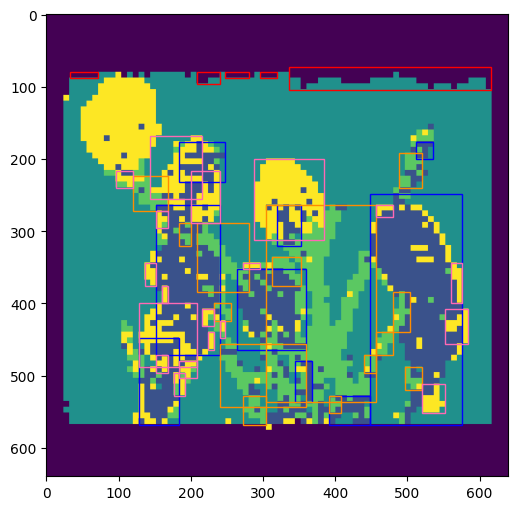

total_bboxes:  47


In [56]:
import matplotlib.patches as patches

mask_attn = 0.8*NormalizeTensor(cls_attn)+0.2*NormalizeTensor(attn)

fig, ax = plt.subplots()
#ax.imshow(mask*255)
ax.imshow(partitinoed)
colors = ['b','g','r','darkorange','hotpink','sienna','black','darkviolet','pink','wheat']
bboxes = []
tot_bboxes = 0
for c in range(k):
    bbox = np.unique(tot_labels[c])

    for i in bbox[1:]:
        idx = np.where(tot_labels[c]==i)
        
        if np.mean([mask_attn[idx[0][i],idx[1][i]] for i in range(len(idx[0]))]) < mask_attn.mean():
            continue
        x1 = np.min(idx[0]); x2 = np.max(idx[0])
        y1 = np.min(idx[1]); y2 = np.max(idx[1])
        if (((x2-x1) > 1) or ((y2-y1) > 1)) and not (y1==0 and x1==0) :
            rect = patches.Rectangle((y1*8, x1*8), (y2-y1+1)*8, (x2-x1+1)*8, linewidth=1, edgecolor=colors[c], facecolor='none')
            #img = cv2.rectangle(img, (x1,y1), (x2,y2), (0,0,255))
            bboxes.append([x1, y1, x2, y2])
            ax.add_patch(rect)
            tot_bboxes +=1

plt.show()
print("total_bboxes: ", tot_bboxes)

In [ ]:
plt.imshow((cls_attn*1e5)*(attn*1e-1)) # softmax 써서 비교해보기

In [ ]:
plt.imshow(attn)

In [66]:
mask_attn = 0.8*NormalizeTensor(cls_attn)+0.2*NormalizeTensor(attn)
def get_bbox(tot_labels, c):
    bboxes = []
    tot_bboxes = 0
    for c in range(k):
        bbox = np.unique(tot_labels[c])

        for i in bbox[1:]:
            idx = np.where(tot_labels[c]==i)
        
            if np.mean([mask_attn[idx[0][i],idx[1][i]] for i in range(len(idx[0]))]) < 1e-5:
                continue
            x1 = np.min(idx[0]); x2 = np.max(idx[0])
            y1 = np.min(idx[1]); y2 = np.max(idx[1])

            if (((x2-x1) > 1) or ((y2-y1) > 1)) and not (y1==0 and x1==0):
                bboxes.append([x1, y1, x2, y2])
                tot_bboxes +=1

    return bboxes

In [67]:
#from torchvision.ops import complete_box_iou_loss as box_iou
from torchvision.ops.boxes import box_iou
def nms(bboxes: torch.Tensor, scores: torch.Tensor, iou_threshold: float):
    order = torch.argsort(-scores)
    indices = torch.arange(bboxes.shape[0])
    keep = torch.ones_like(indices, dtype=torch.bool)
    for i in indices:
        if keep[i]:
            bbox = bboxes[order[i]]
            iou = box_iou(bbox[None,...],(bboxes[order[i + 1:]]) * keep[i + 1:][...,None])
            overlapped = torch.nonzero(iou > iou_threshold)
            keep[overlapped + i + 1] = 0
    return order[keep]

In [68]:
def wasserstein_nms_op(dets_wl, scores, order, dets_sorted, iou_threshold, multi_label):
    pass

def wasserstein_nms(dets, scores, iou_threshold, labels=None):
    """Performs non-maximum suppression (NMS) on the rotated boxes according to
    their intersection-over-union (IoU).

    Rotated NMS iteratively removes lower scoring rotated boxes which have an
    IoU greater than iou_threshold with another (higher scoring) rotated box.

    Args:
        boxes (Tensor):  Rotated boxes in shape (N, 5). They are expected to \
            be in (x_ctr, y_ctr, width, height, angle_radian) format.
        scores (Tensor): scores in shape (N, ).
        iou_threshold (float): IoU thresh for NMS.
        labels (Tensor): boxes's label in shape (N,).

    Returns:
        tuple: kept dets(boxes and scores) and indice, which is always the \
            same data type as the input.
    """
    if dets.shape[0] == 0:
        return dets, None
    multi_label = labels is not None
    if multi_label:
        dets_wl = torch.cat((dets, labels.unsqueeze(1)), 1)
    else:
        dets_wl = dets
    _, order = scores.sort(0, descending=True)
    dets_sorted = dets_wl.index_select(0, order)

    keep_inds = wasserstein_nms_op(dets_wl, scores, order, dets_sorted,
                                           iou_threshold, multi_label)
    dets = torch.cat((dets[keep_inds], scores[keep_inds].reshape(-1, 1)),
                     dim=1)
    return dets, keep_inds

In [69]:
tot_bboxes = np.empty((1,4))
for k in [3,5,8]:#range(3,8): # kmeans 개수
    model = KMeans(n_clusters=k, random_state=5)
    model.fit(full_eigen)
    result = model.fit_predict(full_eigen)
    scaled = result / k
    clustered = torch.tensor(scaled).reshape(w_featmap, h_featmap)  

    tot_labels = bwlabel(clustered, 8)

    for c in range(k):
        tot_bboxes = np.concatenate((tot_bboxes, get_bbox(tot_labels, c)),axis=0)

tot_bboxes = tot_bboxes[1:] # get rid of empty bbox

In [70]:
len(tot_bboxes)

1038

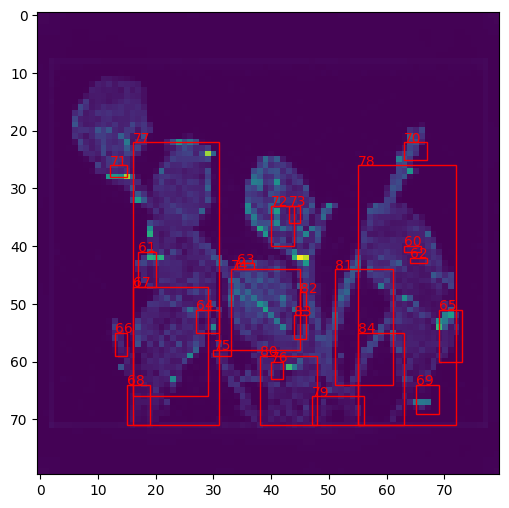

In [71]:
fig, ax = plt.subplots()
ax.imshow(cls_attn)

tot_bboxes = np.array(tot_bboxes, dtype=np.int32)

for i in range(len(tot_bboxes))[60:85]:
    [x1, y1, x2, y2] = tot_bboxes[i]
    rect = patches.Rectangle((y1, x1), (y2-y1+1), (x2-x1+1), linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    t_box=plt.text(y1, x1, i,  color='red', fontsize=10)

plt.show()

In [927]:
tot_bboxes[149]

array([33, 57, 34, 59], dtype=int32)

In [926]:
np.array([np.mean(np.array(cls_attn[bbox[0]:bbox[2]+1,bbox[1]:bbox[3]+1]))*100 for bbox in tot_bboxes])[149:150]

array([0.071822])

NameError: name 'cls_attn_np' is not defined

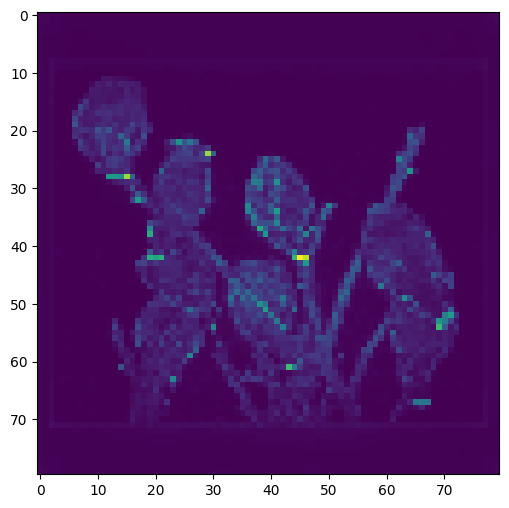

In [72]:
fig, ax = plt.subplots()
ax.imshow(cls_attn)

tot_bboxes = np.array(tot_bboxes, dtype=np.int32)

for i in range(len(tot_bboxes))[30:40]:
    [x1, y1, x2, y2] = tot_bboxes[i]
    bbox = tot_bboxes[i]
    cls_samp = np.array(np.mean(cls_attn_np[bbox[0]:bbox[2]+1,bbox[1]:bbox[3]+1]*100))
    if cls_samp < 0.1:
        continue
    rect = patches.Rectangle((y1, x1), (y2-y1+1), (x2-x1+1), linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    t_box=plt.text(y1, x1, i,  color='red', fontsize=10)

plt.show()

[  0   7   9  16  18  25  27  30  35  37  41  45  47  50  52  55  60  62
  66  70  72  75  77  80  85  87  91  95  97 100 102 105 110 112 116 120
 122 125 127 129 130 131 134 139 146 148 150 151 152 156 158 160 161 162
 165 170 177 179 181 182 183 187 189 191 192 193 196 201 208 210 212 213
 214 218 220 222 223 224 227 232 239 241 243 244 245 249 251 253 254 255
 258 263 270 272 274 275 276 280 282 284 290 293 294 296 299 302 307 309
 310 315 316 319 321 327 330 331 333 336 339 344 346 347 352 353 356 358
 364 367 368 370 373 376 381 383 384 389 390 393 395 401 404 405 407 410
 413 418 420 421 426 427 430 432 438 441 442 444 447 450 455 457 458 463
 464 467 469 475 478 479 481 484 487 492 494 495 500 501 504 505 509 510
 514 515 517 532 538 541 545 547 548 550 551 555 556 560 561 563 578 584
 587 591 593 594 596 597 601 602 606 607 609 624 630 633 637 639 640 642
 643 647 648 652 653 655 670 676 679 683 685 686 688 689 693 694 698 699
 701 716 722 725 729 731 732 734 735 739 740 744 74

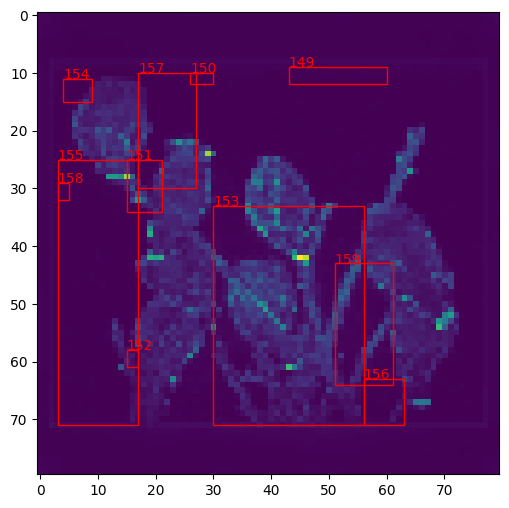

In [932]:
fig, ax = plt.subplots()
ax.imshow(cls_attn)

tot_bboxes = np.array(tot_bboxes, dtype=np.int32)
idx = np.where(np.array(cls_scores) > 0.05)[0]
print(idx)
bboxes = tot_bboxes[idx]

for i in range(len(bboxes))[149:160]:
    [x1, y1, x2, y2] = bboxes[i]
    rect = patches.Rectangle((y1, x1), (y2-y1+1), (x2-x1+1), linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    t_box=plt.text(y1, x1, i,  color='red', fontsize=10)

plt.show()

In [934]:
bboxes[149:160]

array([[ 9, 43, 11, 59],
       [10, 26, 11, 29],
       [25, 15, 33, 20],
       [58, 15, 60, 16],
       [33, 30, 70, 55],
       [11,  4, 14,  8],
       [25,  3, 70, 16],
       [63, 56, 70, 62],
       [10, 17, 29, 26],
       [29,  3, 31,  4],
       [43, 51, 63, 60]], dtype=int32)

In [931]:
np.array([np.mean(cls_attn_np[bbox[0]:bbox[2]+1,bbox[1]:bbox[3]+1])*100 for bbox in bboxes])[149:160]

array([0.00201622, 0.00189571, 0.01166284, 0.00271787, 0.01398042,
       0.00182917, 0.01230511, 0.00231936, 0.0049839 , 0.00969896,
       0.02134205])

In [79]:
cls_scores

array([0.14110544, 0.10651599, 0.030058  , ..., 0.03729302, 0.35786582,
       0.01349086])

In [77]:
np.array([np.max(np.array(mask_attn[bbox[0]:bbox[2]+1,bbox[1]:bbox[3]+1]))*100 for bbox in tot_bboxes])

array([42.57799089, 38.85207772, 23.27009737, ..., 21.55253291,
       90.28391838, 18.35105568])

In [ ]:
fig, ax = plt.subplots()
ax.imshow(cls_attn)

cls_scores = np.array([np.max(np.array(mask_attn[bbox[0]:bbox[2]+1,bbox[1]:bbox[3]+1]))*100 for bbox in tot_bboxes])
# max값 써보기 
tot_bboxes = np.array(tot_bboxes, dtype=np.int32)
idx = np.where(np.array(cls_scores) > 0.2)[0]
bboxes = tot_bboxes[idx]
scores = cls_scores[idx]
selected = nms(torch.Tensor(bboxes), torch.Tensor(scores), iou_threshold=0.3)#, conf_threshold=0.05)
for i in selected:
    [x1, y1, x2, y2] = bboxes[i]
    rect = patches.Rectangle((y1, x1), (y2-y1+1), (x2-x1+1), linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

plt.show()

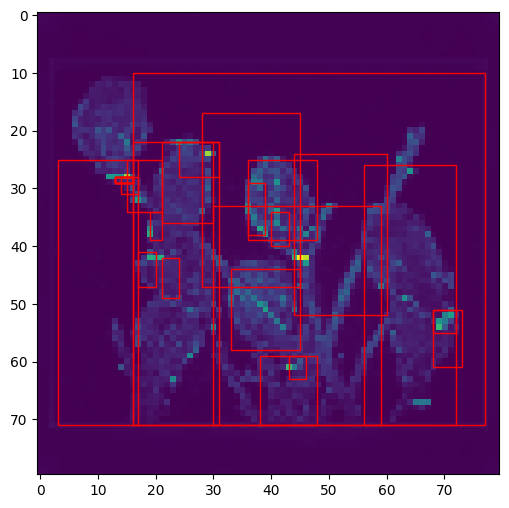

In [89]:
fig, ax = plt.subplots()
ax.imshow(cls_attn)

cls_scores = np.array([np.max(np.array(cls_attn[bbox[0]:bbox[2]+1,bbox[1]:bbox[3]+1]))*100 for bbox in tot_bboxes])
# max값 써보기 
tot_bboxes = np.array(tot_bboxes, dtype=np.int32)
idx = np.where(np.array(cls_scores) > 0.2)[0]
bboxes = tot_bboxes[idx]
scores = cls_scores[idx]
selected = nms(torch.Tensor(bboxes), torch.Tensor(scores), iou_threshold=0.3)#, conf_threshold=0.05)
for i in selected:
    [x1, y1, x2, y2] = bboxes[i]
    rect = patches.Rectangle((y1, x1), (y2-y1+1), (x2-x1+1), linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

plt.show()

In [90]:
cls_scores

array([0.14110544, 0.10651599, 0.030058  , ..., 0.03729302, 0.35786582,
       0.01349086])

In [941]:
cls_scores

array([0.00031199, 0.00023671, 0.000414  , ..., 0.00024392, 0.00023894,
       0.0004722 ], dtype=float32)

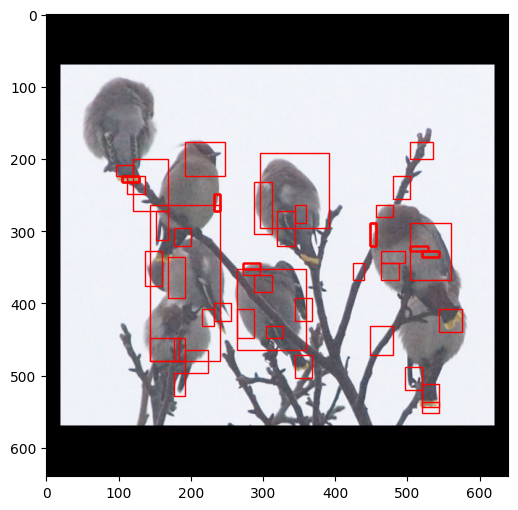

In [952]:
fig, ax = plt.subplots()
ax.imshow(orig_img)

tot_bboxes = np.array(tot_bboxes, dtype=np.int32)
cls_scores = np.array([np.mean(np.array(cls_attn[bbox[0]:bbox[2]+1,bbox[1]:bbox[3]+1]))*100 for bbox in tot_bboxes])
idx = np.where(np.array(cls_scores) > 0.03)[0]
bboxes = tot_bboxes[idx]
scores = cls_scores[idx]
selected = nms(torch.Tensor(bboxes), torch.Tensor(scores), iou_threshold=0.06)
for i in selected:
    [x1, y1, x2, y2] = bboxes[i]
    rect = patches.Rectangle((y1*8, x1*8), (y2-y1+1)*8, (x2-x1+1)*8, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

plt.show()

In [820]:
cls_samp = np.array([np.mean(cls_attn_np[bbox[0]:bbox[2]+1,bbox[1]:bbox[3]+1])*100 for bbox in tot_bboxes])[30:40]
cls_samp

array([0.13845112, 0.01744581, 0.04123461, 0.02867366, 0.00690451,
       0.09903808, 0.04063089, 0.12376587, 0.00925922, 0.04937023])

In [ ]:
idx = np.where(np.array(cls_samp) > 0.1)


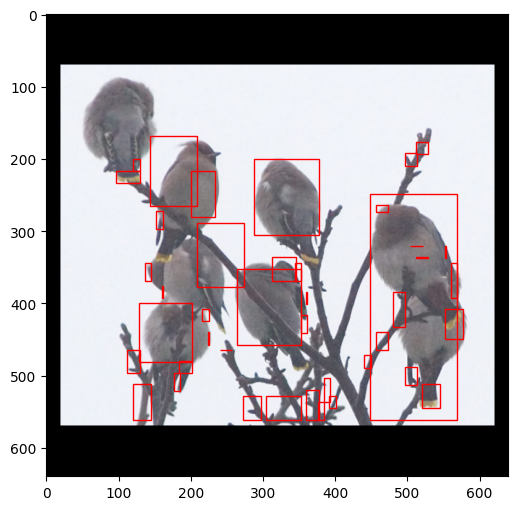

In [659]:
import matplotlib.patches as patches
mask = np.array(clustered==0.1, dtype=bool) # True or false

fig, ax = plt.subplots()
ax.imshow(orig_img)

cls_scores = np.array([np.mean(cls_attn_np[bbox[0]:bbox[2]+1,bbox[1]:bbox[3]+1]) for bbox in bboxes])
selected = nms(torch.Tensor(bboxes), torch.Tensor(cls_scores), iou_threshold=0.06)
#selected = np.array([bboxes[np.argmax(cls_scores)]])

for i in selected:
    [x1, y1, x2, y2] = bboxes[i]
    rect = patches.Rectangle((y1*8, x1*8), (y2-y1)*8+1, (x2-x1)*8+1, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

plt.show()

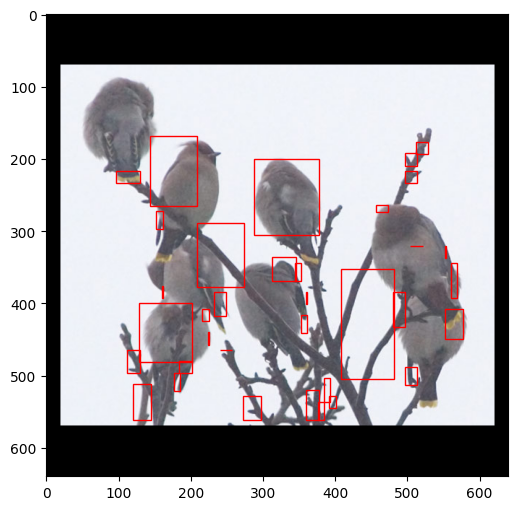

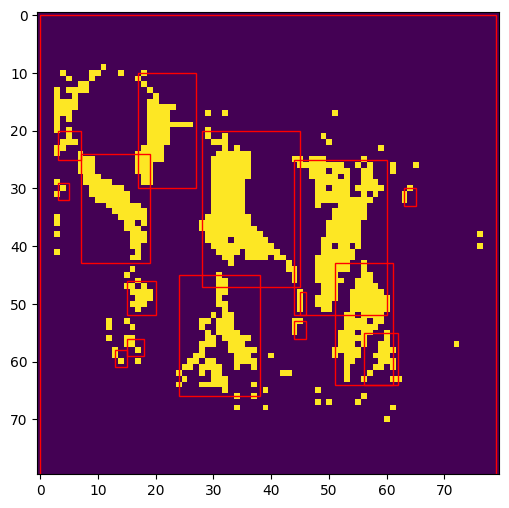

In [418]:
import matplotlib.patches as patches
mask = np.array(clustered==0.1, dtype=bool) # True or false

fig, ax = plt.subplots()
ax.imshow(mask*255)

c=1
bbox = np.unique(tot_labels[c])

for i in bbox[1:]:
    idx = np.where(tot_labels[c]==i)
    x1 = np.min(idx[0]); x2 = np.max(idx[0])
    y1 = np.min(idx[1]); y2 = np.max(idx[1])
    if ((x2-x1) > 1) or ((y2-y1) > 1):
        rect = patches.Rectangle((y1, x1), (y2-y1)+1, (x2-x1)+1, linewidth=1, edgecolor='r', facecolor='none')
        #img = cv2.rectangle(img, (x1,y1), (x2,y2), (0,0,255))
        ax.add_patch(rect)

plt.show()

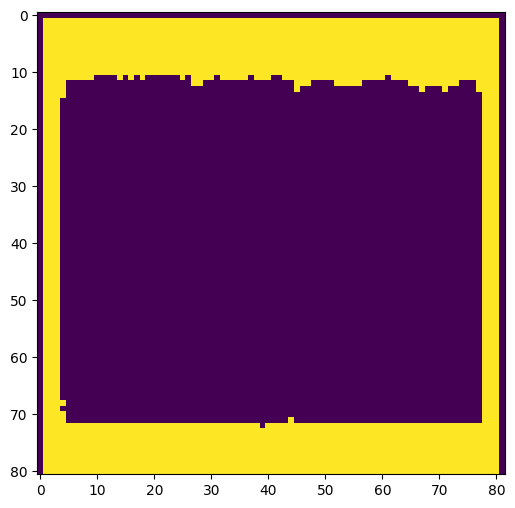

In [266]:
data = np.pad(mask, ((1,0),(1,1)), 'constant',constant_values=0)
plt.imshow(data)

143


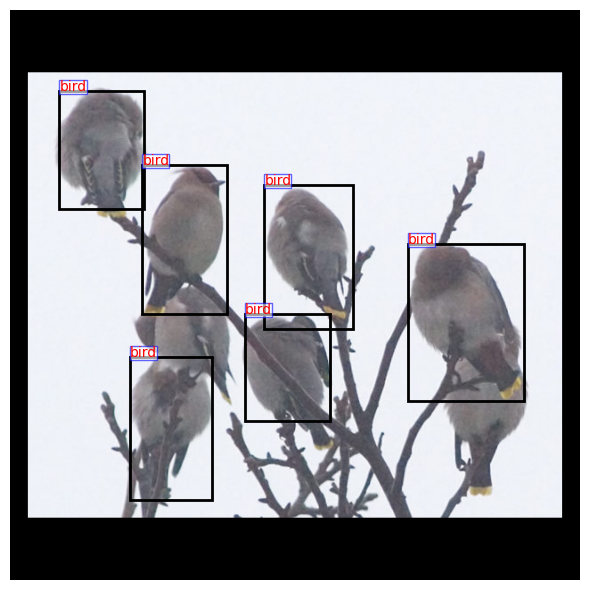

In [137]:
get_gt(args.image_path, orig_img, pad)

In [ ]:
# Padding으로 같은 사이즈 만들어서 해보기

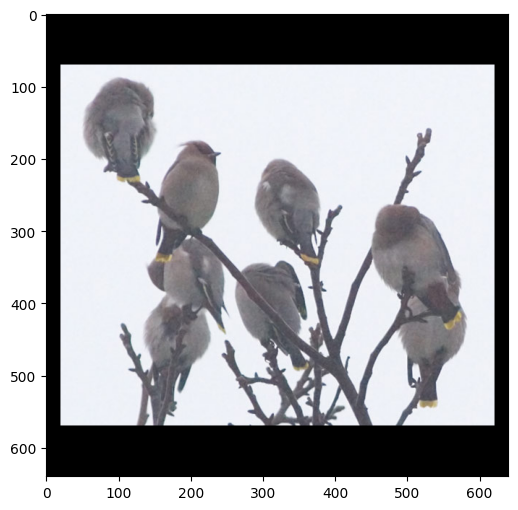

In [452]:
plt.imshow(orig_img)

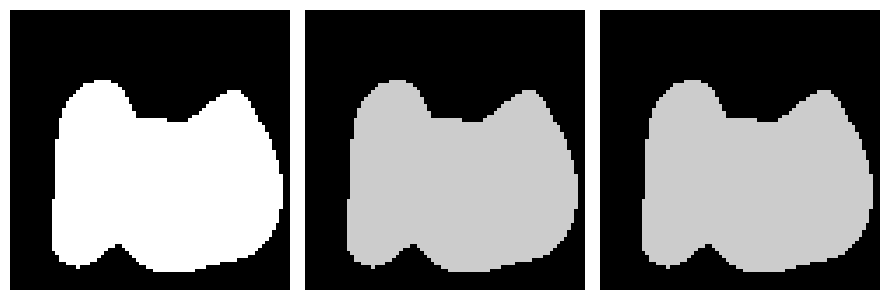

In [194]:
from skimage import measure
from skimage import filters
import matplotlib.pyplot as plt
import numpy as np

#n = 12
#l = 256
#np.random.seed(1)
#im = np.zeros((l, l))
#points = l * np.random.random((2, n ** 2))
#im[(points[0]).astype(np.int), (points[1]).astype(np.int)] = 1
im = mask
im = filters.gaussian(im, sigma= l / (4. * n))
blobs = im > 0.7 * im.mean()

all_labels = measure.label(blobs)
blobs_labels = measure.label(blobs, background=0)

plt.figure(figsize=(9, 3.5))
plt.subplot(131)
plt.imshow(blobs, cmap='gray')
plt.axis('off')
plt.subplot(132)
plt.imshow(all_labels, cmap='nipy_spectral')
plt.axis('off')
plt.subplot(133)
plt.imshow(blobs_labels, cmap='nipy_spectral')
plt.axis('off')

plt.tight_layout()
plt.show()

In [156]:
n = 12
l = 256
np.random.seed(1)
im = np.zeros((l, l)) # 256, 256
im.shape

(256, 256)